In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_04 import *

# Initial setup

In [3]:
x_train, y_train, x_valid, y_valid = get_data()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

In [4]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [5]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [6]:
learn = create_learner(get_model, loss_func, data) # default lr is 0.5 in get_model
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.6647103125, tensor(0.8097)]
valid: [0.3747031982421875, tensor(0.8839)]
train: [0.30409294921875, tensor(0.9114)]
valid: [0.2523560791015625, tensor(0.9284)]
train: [0.24483654296875, tensor(0.9298)]
valid: [0.2151006591796875, tensor(0.9420)]


In [7]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.747547109375, tensor(0.8089)]
valid: [0.352033447265625, tensor(0.9011)]
train: [0.340920703125, tensor(0.9025)]
valid: [0.27916748046875, tensor(0.9220)]
train: [0.29106853515625, tensor(0.9168)]
valid: [0.258016357421875, tensor(0.9297)]


In [8]:
#export
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

## Annealing

We define two new callbacks: the Recorder to save track of the loss and our scheduled learning rate, and a ParamScheduler that can schedule any hyperparameter as long as it's registered in the state_dict of the optimizer. 

In [9]:
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs, self.losses = [], []
        
    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])# In fastai we tend to use the lr of the final layer_group as we have a lot of diff lrs for different layer_groups.
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lr(self): plt.plot(self.lrs)
        
    def plot_loss(self): plt.plot(self.losses)
class ParamScheduler(Callback):
    _order = 1
    def __init__(self, pname, sched_func): self.pname, self.sched_func = pname, sched_func
    
    def set_param(self):
        for pg in self.opt.param_groups:# param_groups same as layer_groups in fastai
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
            
    def begin_batch(self):
        if self.in_train: self.set_param() 

We create a Recorder class as its pretty hard to know that something's working unless you can see it.

Let's start with a simple linear schedule going from start to end. It returns a function that takes a `pos` argument (going from 0 to 1) such that this function goes from `start` (at `pos=0`) to `end` (at `pos=1`) in a linear fashion.

In [10]:
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos*(end-start)
    return partial(_inner, start, end)

Refactoring it with a decorator

In [11]:
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos):
    return start + pos* (end-start)

In [12]:
# sched_lin()

In [13]:
f = sched_lin(1,2)

In [14]:
f(0.3), f(0.5)# what should lr be 30 & 50% of the way through training

(1.3, 1.5)

And here are other scheduler functions:

In [15]:
#export
@annealer
def sched_cos(start, end, pos): return start +(1+ math.cos(math.pi*(1-pos))) * (end-start) / 2

@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

@annealer
def sched_no(start, end, pos): return start

# This monkey patch is there to be able to plot tensors.
# ndim tells matplotlib how many dimensions there are.
torch.Tensor.ndim = property(lambda x: len(x.shape))

In [16]:
annealings = "NO LINEAR COS EXP". split()
annealings

['NO', 'LINEAR', 'COS', 'EXP']

In [17]:
p = torch.linspace(0.01, 1, 10)
p

tensor([0.0100, 0.1200, 0.2300, 0.3400, 0.4500, 0.5600, 0.6700, 0.7800, 0.8900,
        1.0000])

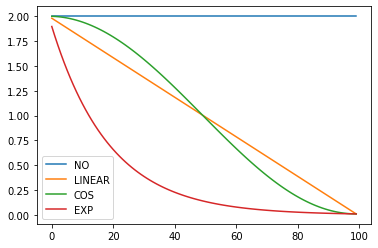

In [18]:
a = torch.arange(0,100)
p = torch.linspace(0.01, 1, 100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label= t)
    plt.legend()

In practice, we'll often want to combine different schedulers, the following function does that: it uses `scheds[i]` for `pcts[i]` of the training.

In [20]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts>= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos>= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx])/ (pcts[idx+1]- pcts[idx])
        return scheds[idx](actual_pos)
    return _inner        

Here is an example: use 30% of the budget(inputs/batches) to go from 0.3 to 0.6 following a cosine, then the last 70% of the budget to go from 0.6 to 0.2, still following a cosine.

In [21]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

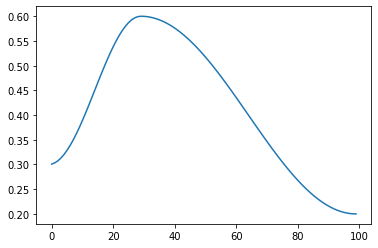

In [22]:
plt.plot(a, [sched(o) for o in p])

We can use it for training quite easily...

In [23]:
cbfs = [Recorder,
       partial(AvgStatsCallback, accuracy),
       partial(ParamScheduler, 'lr', sched)]

In [24]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [25]:
run.fit(3, learn)

train: [0.770986328125, tensor(0.7930)]
valid: [0.4053299072265625, tensor(0.8682)]
train: [0.2997938671875, tensor(0.9120)]
valid: [0.2445391845703125, tensor(0.9301)]
train: [0.24155150390625, tensor(0.9308)]
valid: [0.2158880615234375, tensor(0.9372)]


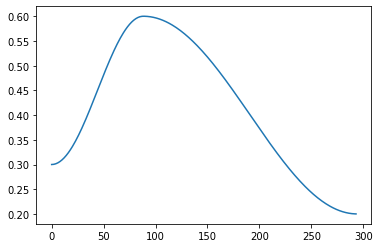

In [26]:
run.recorder.plot_lr()

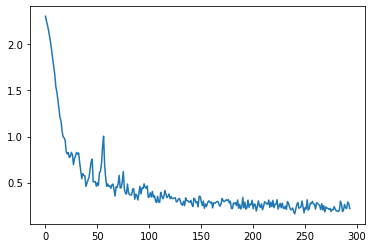

In [27]:
run.recorder.plot_loss()

## Export

In [26]:
!python notebook2script.py 05_anneal.ipynb

Converted 05_anneal.ipynb to exp\nb_05.py
